In [74]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from operator import attrgetter
from datetime import timedelta

In [75]:
# df1 - olist_customers_datase.csv 
# df2 - olist_orders_dataset.csv 
# df3 - olist_order_items_dataset.csv
customers_dataset = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/QXrVDUoQvFhIcg')
orders_dataset = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0zWmh1bYP6REbw')
order_items_dataset = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg')

# Предобработка данных

In [114]:
print(customers_dataset.info())
print(orders_dataset.info())
print(order_items_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purch

На первый взгляд с данными должно быть всё в порядке, но во втором датафрейме в трех столбцах под номерами 4,5,6 мы видим пропущенные значения. Во втором и третьем датафрейме несколько столбцов должны быть представлены в формает даты, однако на данный момент они представлены в строковом формате. Исправим этот момент. 

In [77]:
#Преобразуем столбцы в двух датафреймах в формат "datetime"
orders_dataset[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders_dataset[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
order_items_dataset['shipping_limit_date'] = pd.to_datetime(order_items_dataset['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')

Вопрос с типом данных в колонках решен. Осталось решить проблему с пропущенными значениями. Для начала рассмотрим, какое количесвто пропущенных значений содержится в колонках каждого даатфрейма

In [78]:
customers_dataset.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [79]:
orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [80]:
order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Итак, во втором датафрейме пы получили несколько столбцов с пропущенными значениями(order_approved_at, order_delivered_carrier_date, order_delivered_customer_date).

Сформируем отдельный датафрейм и посмотрим на данные с пропущенными значениями подробнее. 

In [81]:
missing_values = orders_dataset\
    .query("(order_approved_at == 'NaT') & (order_delivered_carrier_date == 'NaT') & (order_delivered_customer_date == 'NaT')")

Каждую колонку: "order_approved_at, order_delivered_carrier_date, order_delivered_customer_date" мы можем расценивать как определденный "этап жизни" заказа. order_approved_at —  время подтверждения оплаты заказа, order_delivered_carrier_date —  время передачи заказа в логистическую службу, order_delivered_customer_date —  время доставки заказа. Предварительно можно сказать, что в колонке "order_approved_at" пустые знаения могут быть связаны с тем, что оплата не прошла. В колонке "order_delivered_carrier_date" пустые значения скорее всего связаны с тем, что продавец не передал заказ логистической службе. Ну и очевидно, что в последней интересующей нас колонке пропущенные значения обсулсолены тем, что заказ попросту не дошел до покупателя. Из дополнительной информации у нас есть статусы заказов:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

Для того, чтобы определить, что мы будем считать покупкой посмотрим на статусы заказов. Нас точно не будут интересовать закзы со статусом "canceled" и "unavailable", так как в этом случае становится очевидно, что данные заказы мы не можем отнести к покупкам. Остальные статусы скорее всего связаны с тем, что заказ находится на одном из определенных этапов своего жизненного цикла. 

Что более важно - это факт оплаты заказа. Будем считать, что для нас покупка - это оплаченный товар(order_approved_at != 0), у которого статус не "canceled" или "unavailable".

Мы определились с тем, что мы будем считать покупкой, но что если в наших данных есть аномалии? Предлагаю их поискать. 
1)Допустим, что у нас не был оплачен заказ, но статус заказа delivered
2)Допустим, что у нас есть данные, где заказ был доставлен, но не передан в логистическую компани.

Поиск таких аномалий поможет сделать вывод о специфике ведения бизнеса клиента.


In [82]:
anomaly1 = orders_dataset.query("(order_approved_at == 'NaT') & (order_status == 'delivered')") 
#Действительно, такие заказы есть.

In [83]:
anomaly2 = orders_dataset.query("(order_delivered_carrier_date== 'NaT') & (order_status == 'delivered')") 
#Да, и такие заказы есть.

По первому пункту я могу выдивгуть следующее предположение: оплата за заказ может осуществлена наличными или другими способами без подтверждения оплаты на сайте. (что странно для электронной коммерции)
По второму пункту следующее предположение: возможно продавец может продавать товары, не использую услуги партнера в лице логистической службы. Стоит ли включать первый пункт в общий список совершенных покупок? Я думаю, что да. Так или иначе, статус "delivered" говорит о том, что мы продали один товар, а следовательно получили деньги за него, однаки каким способом история умалчивает. Далее перейдем к выполнению когортного анализа и RFM-сегментации

# Когортный анализ

Выполним когортный анализ пользователей.

Выявим когорту с самым высоким retention на 3-й месяц.

определим основные параметры:

1. Признак формирования когорты: первая покупка;
2. Размер когорты: месяц
3. Отчетный период: c 2016-09-15 по 2018-09-03(весь период)
4. Анализируемый ключевой показатель: Retention Rate

В качестве первой покупки будет считать данные из столбца "order_approved_at", так как покупка считается покупкой только в случае оплаты товара.

In [84]:
#Объединим orders_dataset и customer_dataset в единый датафрейм
cohort_df = orders_dataset.merge(customers_dataset, how = 'inner', on ='customer_id')

#Отберем покупки и избавимся от дупликатов по колонке 'order_id'
cohort_df = cohort_df\
    .query("((order_status != ['canceled', 'unavailable']) & (order_approved_at != 'NaT')) or ((order_approved_at == 'NaT') & (order_status == 'delivered'))")\
    .drop_duplicates(subset = 'order_id')

In [85]:
#Отберем минимальную и максимуальную дату за указанный период
start_date = cohort_df['order_approved_at'].min()
end_date = cohort_df['order_approved_at'].max()

#Отфильтруйте данные по заданному диапазону дат
cohort_df = cohort_df[(cohort_df['order_approved_at'] >= start_date) & (cohort_df['order_approved_at'] <= end_date)]

In [86]:
#Сформируем столбец с первым месяцем покупки по каждому пользователю
cohort_df['first_order_month'] = cohort_df['order_approved_at'].dt.to_period('M')

In [87]:
#Формируем когорту из покупателей, которые совершили свою первую покупку за указанный период(в размере месяца)
cohort_df['cohort'] = cohort_df\
    .groupby('customer_unique_id')['order_approved_at']\
    .transform('min').dt.to_period('M')

In [88]:
#Посчитаем число уникальных покупателей в каждой когорте
df_cohort = cohort_df\
    .groupby(['cohort', 'first_order_month'])\
    .agg(n_customers=('customer_unique_id', 'nunique'))\
    .reset_index(drop=False)

In [89]:
#Получим индексы когорт
df_cohort['period'] = (df_cohort.first_order_month - df_cohort.cohort).apply(attrgetter('n')) #Получаем индексы когорт

In [90]:
#Формируем сводную таблицу
pivot_table = df_cohort.pivot_table(index='cohort', columns='period', values='n_customers')#
cohort_size = pivot_table.iloc[:, 0]
retention_matrix = pivot_table.divide(cohort_size, axis=0)
retention_rates = retention_matrix.iloc[:, 3]  
max_retention_cohort = retention_rates.idxmax()

print(f"Когорта с наибольшим retention rate за третий месяц: {max_retention_cohort}")

Когорта с наибольшим retention rate за третий месяц: 2017-05


In [91]:
cohort_graph = (retention_matrix
        .style
        .set_caption('User retention by cohort')
        .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
        .highlight_null('white')  # делаем белый фон для значений NaN
        .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
cohort_graph

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.34%,,,0.34%,,0.34%,,0.34%,,0.34%,,0.34%,0.69%,0.69%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.56%,0.28%,0.14%,0.42%,0.14%,0.42%,0.14%,0.14%,,0.28%,0.28%,0.70%,0.42%,0.14%,0.14%,0.28%,0.42%,0.14%,
2017-02,100.00%,0.24%,0.24%,0.18%,0.42%,0.12%,0.24%,0.18%,0.06%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,,
2017-03,100.00%,0.50%,0.35%,0.35%,0.35%,0.16%,0.16%,0.31%,0.31%,0.12%,0.39%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,,
2017-04,100.00%,0.61%,0.22%,0.17%,0.26%,0.26%,0.35%,0.26%,0.35%,0.17%,0.22%,0.09%,0.09%,0.04%,0.09%,0.09%,0.13%,,,
2017-05,100.00%,0.54%,0.48%,0.40%,0.31%,0.34%,0.42%,0.14%,0.25%,0.25%,0.28%,0.34%,0.20%,0.06%,0.20%,0.23%,,,,
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.35%,0.35%,0.23%,0.13%,0.23%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,


# Ответ: Когорта с наибольшим retention rate за третий месяц: 2017-05

# RFM-сегментация

Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [92]:
#Объединим три датафрейма в один
RFM_df = order_items_dataset.merge(orders_dataset, how = 'inner', on = 'order_id').merge(customers_dataset, how = 'inner', on = 'customer_id') 

#Снова отберем покупки

RFM_df= RFM_df.query("((order_status != ['canceled', 'unavailable']) & (order_approved_at != 'NaT')) or ((order_approved_at == 'NaT') & (order_status == 'delivered'))")

#Мы не будем убирать дубликаты. Нам необходимо посчитать выурчку с продажи каждого товара, а, как мы помним, в каждом заказе у нас может быть несколько товаров, которые в переменной "order_item_id" нумируются по порядку

In [93]:
#Посмотрим на количество строк и колонок в получившимся датафрейме
print('{:,} rows; {:,} columns'.format(RFM_df.shape[0], RFM_df.shape[1]))

112,101 rows; 18 columns


Определимся с сегодняшней датой. Так как данные довольно старые, то будет разумно, если мы за "сегодняшнюю дату" для нашего анализа возьмем последнюю дату покупки + 1 день

In [94]:
nowadays = RFM_df['order_approved_at'].max() + timedelta(days = 1)
nowadays

Timestamp('2018-09-04 17:40:06')

In [95]:
# Считаем количество товаров в каждом чеке.
RFM_df['total_items'] = RFM_df\
    .groupby('order_id')['order_item_id']\
    .transform('count')

In [96]:
#Посчитаем итоговую сумму по каждому заказу
RFM_df1 = RFM_df\
    .groupby(['order_id', 'customer_unique_id', 'order_approved_at'])\
    .agg({'price' : 'sum'}).sort_values('order_approved_at')\
    .reset_index()
RFM_df1

,order_id,customer_unique_id,order_approved_at,price
0,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,134.97
1,1ff217aa612f6cd7c4255c9bfe931c8b,14359ea0c7a105749c0a56478825b015,2016-10-04 09:43:32,32.49
2,cd3b8574c82b42fc8129f6d502690c3e,87776adb449c551e74c13fc34f036105,2016-10-04 10:19:23,29.99
3,ed8c7b1b3eb256c70ce0c74231e1da88,88bc832f104b6dd684a17dbb1b76e778,2016-10-04 10:25:46,89.90
4,d207cc272675637bfed0062edffd0818,8d3a54507421dbd2ce0a1d58046826e0,2016-10-04 10:28:07,119.90
...,...,...,...,...
98180,168626408cb32af0ffaf76711caae1dc,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:30:23,45.90
98181,0b223d92c27432930dfe407c6aea3041,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:31:07,418.00
98182,03ef5dedbe7492bdae72eec50764c43f,b701bebbdf478f5500348f03aff62121,2018-08-29 15:05:22,24.90
98183,35a972d7f8436f405b56e36add1a7140,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:10:26,84.99


Вводим три переменные: Recency, Frequency, Monetary

In [97]:
rfm_df = RFM_df1\
    .groupby('customer_unique_id', as_index = False)\
    .agg({'order_approved_at' : lambda x: (nowadays - x.max()).days, 'order_id' : 'nunique', 'price' : 'sum'})\
    .rename(columns = {'order_approved_at' : 'Recency', 'order_id' : 'Frequency', 'price' : 'Monetary'})

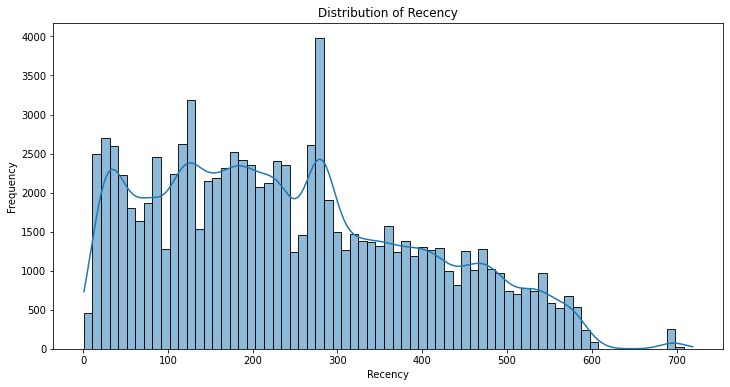

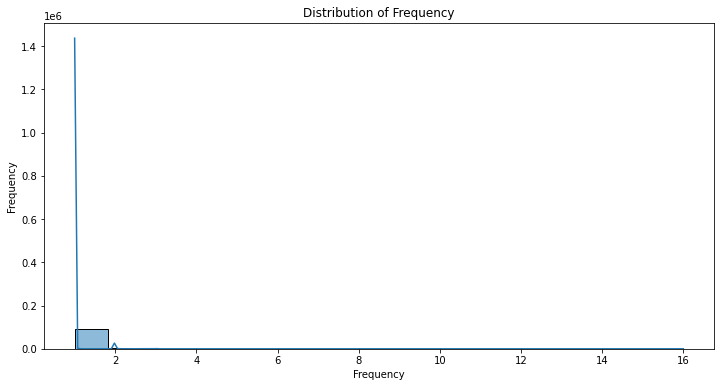

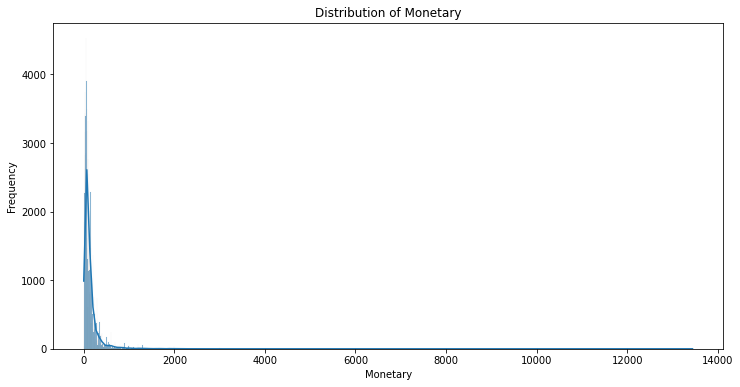

In [98]:
#Построим графикы распределения переменных 
RFM_columns = ['Recency', 'Frequency', 'Monetary']

for col in RFM_columns:
    fig, ax = plt.subplots(figsize=(12, 6))  
    sns.histplot(rfm_df[col], kde=True, ax=ax) 
    ax.set_title('Distribution of %s' % col)
    ax.set_xlabel(col) 
    ax.set_ylabel('Frequency')  
    plt.show()

In [99]:
#Рассмотрим основные статистические показатели по нашим показателям, это поможет нам в будущем при сегментации пользователей
rfm_df[['Recency', 'Frequency', 'Monetary']].mean()

Recency      243.475519
Frequency      1.033853
Monetary     142.073605
dtype: float64

In [100]:
rfm_df[['Recency', 'Frequency', 'Monetary']].mode()

,Recency,Frequency,Monetary
0,132,1,59.9


In [101]:
rfm_df[['Recency', 'Frequency', 'Monetary']].median()

Recency      224.00
Frequency      1.00
Monetary      89.89
dtype: float64

Исходя из информации, полученной из графиков, все три наши переменные довольно сильно отличаются от нормального распределения

На графике, который описывает переменную **"Recency"** мы видим, что распределение немного смещено влево. Функция mode() показывет, что распределение переменной унимодально, однако, судя по графику, распределение полимодально. Если оценивать распределение переменной в общих чертах, то можно скзаать, что покупателей, которые купили товар/товары сравнительно недавно больше, нежели покупателей, которые приобретали товары давно. 

Графики **"Frequency" и "Monetary"** визуально схожи между собой: наибольшее скопление данных наблюдается в начале распределения. На самом деле, это вполне очевидно. В случае с **"Monetary"** людей, которые потратили на товары сравнительно небольшую сумму, будет гораздо больше, чем тех, кто потратил на покупки большие деньги. Скорее всего бизнес ориентирован на розничную торговлю, а не на оптовую, отсюда и такие низкие показатели **"Monetary"**. С переменной **"Frequency"** всё довольно просто: у нас довольно много покупателей, которые совершили покупку только один раз. При присвоении рангов переменным, рассмотрим этот момент подробнее.


In [102]:
#Рассчитаем квантили переменных для того, чтобы на их основе сегментировать пользователей
quintiles = rfm_df[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 98.0, 0.4: 182.0, 0.6: 273.0, 0.8: 388.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Далее присвоим ранги нашим переменным от 1 до 5. Однако есть одно примечание: меньшее значение Recency для нас является более предпочтительным, тогда как Frequency и Monetary - наоборот.

Довольно неопределенная ситуация получилась с Frequency. Большинство покупателей совершило одну покупку. Убедимся в этом.

In [103]:
rfm_df.Frequency.value_counts()

1     92084
2      2650
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: Frequency, dtype: int64

Действительно, тезис, выдвинутый выше,подтверждается. В данном случае мы будем опираться не на квантили, а на собственную разбивку. Итак:

1 покупка - 1 сегмент;

2 покупки - 2 сегмент;

3 покупки - 3 сегмент;

4 покупки - 4 сегмент;

5 и более покупок - 5 сегмент

In [104]:
#Функция для присвоения номера каждому пользователю внутри сегмента
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    elif x <= 4:
        return 4
    else:
        return 5  


def m_score(x):
    if x <= quintiles['Monetary'][.2]:
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5  

In [105]:
rfm_df['R'] = rfm_df['Recency'].apply(lambda x: r_score(x))
rfm_df['F'] = rfm_df['Frequency'].apply(lambda x: f_score(x))
rfm_df['M'] = rfm_df['Monetary'].apply(lambda x: m_score(x))
#разбивка на сегменты

In [106]:
rfm_df['RFM_Score'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)

In [107]:
#В итоге у нас получилось порядка 80 уникальных сегментов. Следующей задачей является описание каждого сегмента
rfm_df.RFM_Score.unique()

array(['414', '411', '112', '211', '215', '315', '114', '413', '111',
       '213', '412', '113', '311', '512', '511', '515', '115', '214',
       '313', '513', '212', '514', '415', '314', '325', '312', '523',
       '123', '425', '525', '225', '125', '422', '223', '324', '524',
       '222', '424', '322', '435', '521', '122', '522', '434', '224',
       '423', '133', '124', '545', '323', '445', '235', '335', '234',
       '421', '221', '152', '534', '355', '533', '334', '535', '321',
       '142', '333', '135', '433', '455', '233', '555', '121', '134',
       '131', '332', '141', '145', '245', '345', '132', '532'],
      dtype=object)

# Сформируем 10 сегментов на основе оценок R и F: 

**Чемпионы** - купили недавно, покупают часто и тратят больше всех

**Постоянные клиенты** - тратят хорошие деньги и часто, реагируя на рекламные акции

**Потенциальный лоялист** - недавние клиенты, но потратили приличную сумму и покупали более одного раза

**Новые клиенты** - покупали совсем недавно, но не часто

**Перспективные** - недавно совершившие покупку, но потратившие не так уж много

**Нуждаются во внимании** - недавность, частота и денежные показатели выше среднего; возможно, покупали не так давно

**Собираются спать** - недавность, частота и денежные показатели ниже среднего; потеряют их, если не активизировать

**Подвержен риску** - тратит большие деньги и покупает часто, но давно; их нужно вернуть

**Нельзя потерять** - совершал крупные покупки и часто, но долго не возвращал

**Переход в спящий режим** - последняя покупка была совершена давно, низкие траты и небольшое количество заказов.

Примечание: **RF-анализ** - анализ по давности и частоте покупок. Показывает, как часто клиенты совершают покупки за анализируемый период. Позволяет выявить клиентов, которые недавно что-то купили и сотрудничают с компанией постоянно.

In [108]:
segt_map = {
    r'[1-2][1-2]': 'Переход в спящий режим',
    r'[1-2][3-4]': 'Подвержен риску',
    r'[1-2]5': 'Нельзя терять',
    r'3[1-2]': 'Собираются спать',
    r'33': 'Нуждаются во внимании',
    r'[3-4][4-5]': 'Постоянные клиенты',
    r'41': 'Перспективные клиенты',
    r'51': 'Новые клиенты',
    r'[4-5][2-3]': 'Потенциальный лоялист',
    r'5[4-5]': 'Чемпики'
}

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)

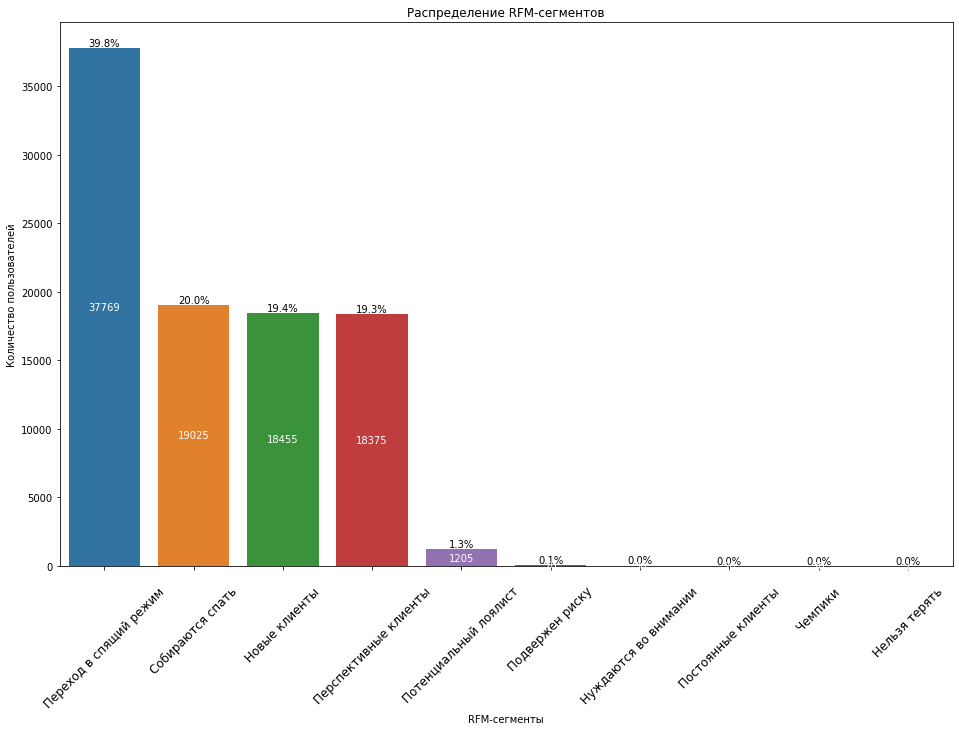

In [109]:
#Посмотрим на количество покупателй по RFM-параметру(визуализация с помощью barplot)
segment_counts = rfm_df.groupby('Segment')['Segment']\
    .count()\
    .to_frame()\
    .rename(columns = {'Segment' : 'amount'})\
    .sort_values("amount", ascending = False)\
    .reset_index()

plt.figure(figsize=(16, 10))

ax = sns.barplot(data=segment_counts, x="Segment", y="amount", estimator=sum, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
ax.tick_params(axis='x', which='major', pad=15)
ax.set(xlabel='RFM-сегменты', ylabel ='Количество пользователей', title = 'Распределение RFM-сегментов')

# Добавим информацию о том, какой процент составляет сегмент от общего числа пользователей

total_users = segment_counts['amount'].sum()

# Добавим процентное значение к каждому столбику
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_users)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)
    
    
    ax.text(x, y/2, f'{int(y)}', ha='center', va='center', color='white', fontsize=10)

plt.show()


К сожалению, представленный выше график не отображает информацию о сегментах, где количество клиентов < 70, поэтому построим treemap, которое предоставит более детальную информацию о каждом сегменте

In [110]:
#Количество клиентов в каждом сегменте(визуализация с помощью treemap)
#График построил, опираясь на официальную документацию plotly
#Знаю, что графики plotly не будут отображаться в GitLab, но без них как-то совсем скучно
segment_counts = rfm_df.groupby('Segment')['Segment']\
    .count()\
    .to_frame()\
    .rename(columns = {'Segment' : 'amount'})\
    .sort_values("amount", ascending = False)\
    .reset_index()

fig_treemap_segment_product = px.treemap(segment_counts,
                                         path=['Segment'],
                                         values='amount',
                                         color='Segment',
                                         color_discrete_sequence=px.colors.qualitative.Pastel,
                                         title='RFM Customer Segments by Value')
fig_treemap_segment_product.show()

In [111]:
#Сегментация клиентов по выручке, которую они принесли
segment_counts = rfm_df.groupby('Segment').agg({'Monetary': 'sum'}) \
    .rename(columns={'Monetary': 'revenue'}) \
    .sort_values("revenue", ascending=False) \
    .reset_index()

fig_treemap_segment_product = px.treemap(segment_counts,
                                         path=['Segment'],
                                         values='revenue',
                                         color='Segment',
                                         color_discrete_sequence=px.colors.qualitative.Pastel,
                                         title='RFM Customer Segments by Value')
fig_treemap_segment_product.show()


Итак, подведем небольшой итог по RFM-анализу:

1. Порядка 40% всех клиентов относятся к сегменту **"Переход в спящий режим"**. Как следует из методологических указаний, такие клиенты, как правило, не возвращаются. Однако можно попробовать отправить им реактивационную рассылку(акции, инетерсные предложения), и если клиент не чиатет рассылку в течение установленного нами срока, то можно удалить его из базы данных. Важно отметить, что клиенты данного сегмента принесли бизнесу наибольшую вырочку, однако, учитывая специфику их покупательского поведения, скорее всего это были разовые покупки со сравнительно небольшими тратами;


2. 20% нашей клиентской базы - это клиенты, которые относятся к сегменту **"Собираются спать"**. Фактически, это клиенты, которые наиболее подвержены риску ухода. Данный сегмент для нас является придпочтительнее, чем **"Переход в спящий режим"**. Наша задача - как можно активнее делиться с ними полезной информацией, предлагать популярные товары. Необходимо предалагать скидки и промокоды, чтобы позволить им покупать больше. Данный сегмент также приносит нашему магазину довольно неплохую выручку.(4 место по выручке среди всех сегментов)


3. **"Новые клиенты"** составляют порядка 19,4% от общего числа клиентов. Наша задача - это условно создать четкое понимание нашего бренда у клиента. При работе с данным сегментом мы должны показать преимущество по сравнению с конкурентами. Предположительно, мы можем дать скидки на первую/вторую крупную трату или же с определенной регулярностью предлагать выгодные промокоды. **"Новые клиенты"** находятся на третьем месте по объему выруки за всё время сущетвования интернет-магазина. 


4. Сегмент **Перспективные клиенты** составляют 19,3% от общего числа клиентов. Как праивло, это клиенты, которые купили товар недавно, но на небольшую сумму. Этот сегмент не зря называется "перспективный", а следовательно к ним нужен особый подход для того, чтобы заинетерсовать их. Наша задача -  увеличить средний чек, предлагать более дорогие товары из ассортимента. Следует сделать наибольший акцент на данный сегмент, так как по принесенной выручке он идет вторым после "Переход в спящий режим".


5. Следующие по спику идут **"Потенциальные лоялисты"**, составив 1,3% от общего числа клиентов. Для данного сегмента мы можем предлагать более дорогие позиции. Данный сегмент, как и **"Постоянных клиентов"** стоит регулярно спрашивать их мнение о покупках, чтобы вовремя понять, что что-то пошло не так. 


6. Далее у нас идут сегменты, где число покупателей составило < 70 человек, однако не стоит про них забывать, ведь именно среди них находятся самые преданные покупатели - **"Чемпики"**. Эксперты рекомендуют не предлагать им акции и скидки, а выделить их среди большинства другими методами. К примеру, можно предложить им доступ к новым товарам, которых ещё нет в продаже. Это не только повысит лояльность, но и поможет собрать качественную обратную связь перед массовым запуском нового продукта(мк примеру, фокус-группа). 


7. Сегмент **"Подвержен риску"** составляет всего  0,1% от всего числа клиентов интернет-магазина, однако не стоит про них забывать, ведь ранее они тратили довольно много. В данном случае оптимальной стратегией будет являться налаживание контакта. В силу того, что количество людей в данном сегменте сравнительно небольшое, мы бы могли отправить персонализированные имейлы с целью возобновления связи. Мы должны сделать так, чтобы клиент почуствовал необходимость в нашем продукте. 


8. Сегмент **"Нуждаются во внимании"** составляют всего 30 человек, но и про них ни в коем случае нельзя забывать. Наша задача - пробудить в них интерес. Эксперты рекомендуют предлагать ограниченные по времени офферы, а также предлагать им офферы на основе прошлых покупок.


9. Сегмент **"Постоянные клиенты"** также относится к малочисленным. Стратегия в случае данного сегмента схожа с сегментов **"Потенциальные лоялисты"**. Нам следует предлагать им более дорогие позиции, можем попросить их оставить отзывы.
